**POPPY ROBOT TUTORIAL**
---

**Students : Anaële BAUDANT-COJAN, Pierre BILLAUD, Edouard DUCLOY**<br>
Teachers : Mai NGUYEN, Damien BOUCHABOU<br>
Cours IA705 - Apprentissage pour la robotique, Master spécialisé IA, Telecom Paris – ENSTA, mai 2024

This tutorial aims at helping other students to discover the Poppy / Coppelia Sim environment, step by step, to become familiar with it specific set-up and constraints. Section 0/ Set-up and 1/ Poppy instanciation are largely inspired from course material provided by Mai NGUYEN and Damien BOUCHABOU (ENSTA).

# 0/ Setup the software

Poppy humanoid robot is a humanoid robot that can be used with its hardware platform or with the CoppeliaSim simulator. It can be programmed with python, using the pypot library.

Download and install the simulator CoppeliaSim from https://www.coppeliarobotics.com/downloads 

**CREATE A PYTHON ENVIRONMENT WITH PYTHON 3.8** later versions are not supported in all libraries

The quick install consists in:
- install **pypot** : library to control robots, including Poppy
    - It is a python library : http://poppy-project.github.io/pypot/. 
- install **poppy_torso** : install your poppy creature with its geometry :
    - On the top of pypot are libraries for Poppy creatures : https://github.com/poppy-project.
- install **ikpy** : this library proposes the inverse kinematics of the robot. 
    - The source code is https://github.com/Phylliade/ikpy. 
    - See tutorial on https://notebook.community/Phylliade/ikpy/tutorials/Moving%20the%20Poppy%20Torso%20using%20Inverse%20Kinematics)
- install **mediapipe** : algorithm for human pose estimation from video (pre-trained "Blazepose" model) :
    - the article describing the algorithm is in https://arxiv.org/abs/2006.10204
    - the source code is still available at https://github.com/google/mediapipe

In [1]:
#!py -m pip install pypot
#!py -m pip install poppy_torso
#!py -m pip install ikpy[plot]
#!pip install mediapipe

In [2]:
import numpy as np
import pprint
import time
import os

from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons

**1/ Instantiate the robot**
---

Now open the simulator CoppeliaSim. Click yes when prompted if you accept all incoming communications. Run the cell below, and Poppy should appear on Coppelia screen. Instantiating poppy will add the kinematic chains attributes.

In [4]:
# Instantiate the poppy robot in the simulator.

from pypot import vrep
vrep.close_all_connections()
poppy = PoppyTorso(simulator='vrep')

For MacOs, type in the Sandbox script terminal :<br>

            > simExtRemoteApiStart(19997)<br>

If instead it does now appear and you get an error message like<br>

            > pypot.vrep.io.VrepConnectionError: Could not connect to V-REP server on 127.0.0.1:19997. This could also means that you still have a previously opened connection running! (try pypot.vrep.close_all_connections())<br>
            > During handling of the above exception, another exception occurred:<br>
            > pypot.vrep.io.VrepIOErrors: No value<br>

type in the Sandbox script terminal:

            simExtRemoteApiStart(19997)

Poppy should now appear on the CoppeliaSim simulation screen, and a popup appeared in CoppeliaSim to inform you that the simulation use custom parameters. This popup block the communication to the Python API of CoppeliaSim. For MacOs, you have to check the check-box “Do not show this message again” and press “Ok”. Do this 3 times.

**2/ Exploring the kinematic chains**
---

# A) How kinematic chains are designed and operated

For each kinematic chain we have built an urdf file. We create an IKChain object for each kinematic chain, making it possible to compute the inverse kinematics, i.e. motor angles from desired end-effector position.

The constructor takes as input the poppy robot instance, the motors that are part of the kinematic chain, the motors that remain passive during the inverse kinematics, the distance of the tip of the last bone of the chain, and finally, the list of motors for which the urdf file give reversed orientation.

We can plot some of these kinematic chains in a figure. If the position of the robot in the simulator is changed, these changes should be reflected when reexecuting this cell.

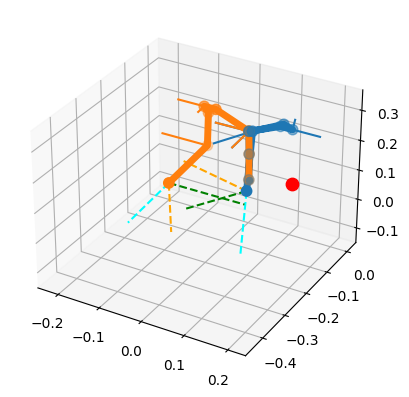

In [ ]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline
zero = [0] * 7

ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')
ax.scatter([0], [0],[0])

poppy.l_arm_chain.plot(poppy.l_arm_chain.convert_to_ik_angles(poppy.l_arm_chain.joints_position), ax, target = (0.2, -0.2, 0.2))
poppy.r_arm_chain.plot(poppy.r_arm_chain.convert_to_ik_angles(poppy.r_arm_chain.joints_position), ax)

The robot is now ready to use.

# B) Exploring le left arm chain (links)

You can directly access the chains:


In [ ]:
# EXPLORE THE LINKS
print("l_arm_chain\n================================")
print("chaine  " , poppy.l_arm_chain)
print("nom     " , poppy.l_arm_chain.name)
print("links   " , poppy.l_arm_chain.links)
print("1er link" , poppy.l_arm_chain.links[1].name)
#print(poppy.torso_chain)
#print(poppy.l_elbow_chain   )
#print(poppy.l_elbow_chain   )

l_arm_chain
chaine   Kinematic chain name=chain links=[Link name=Base link bounds=(None, None), Link name=abs_z bounds=(-4583.662227704603, 4583.662227704603), Link name=bust_y bounds=(-3838.817399424839, 1546.9858942315252), Link name=bust_x bounds=(-2291.8311138523013, 2291.8311138523013), Link name=l_shoulder_y bounds=(-6875.493732897918, 8880.845615095293), Link name=l_shoulder_x bounds=(-6016.056820615171, 6302.535660929083), Link name=l_arm_z bounds=(-6016.056820615171, 6016.056820615171), Link name=l_elbow_y bounds=(-8479.775082119413, 57.29545498997201), Link name=last_joint bounds=(None, None)] active_links=[False False False False  True  True  True  True False]
nom      chain
links    [Link name=Base link bounds=(None, None), Link name=abs_z bounds=(-4583.662227704603, 4583.662227704603), Link name=bust_y bounds=(-3838.817399424839, 1546.9858942315252), Link name=bust_x bounds=(-2291.8311138523013, 2291.8311138523013), Link name=l_shoulder_y bounds=(-6875.493732897918, 8880.8

In [ ]:
# Exploring the characteristics of each links

print("\nl_arm_chain links\n================================")
left_arm_chain_links = [m.name for m in poppy.l_arm_chain.links]
print("all links:",left_arm_chain_links)
print("links with rotation", [m.name for m in poppy.l_arm_chain.links if m.has_rotation])
print("links with no rotation", [m.name for m in poppy.l_arm_chain.links if not m.has_rotation])

for i, link in enumerate(poppy.l_arm_chain.links):
    print(f"\nlink {i} - {link.name} \n-------------------------------- \nlength : {link.length} \naxis length: {link.axis_length}\nhas rotation: {link.has_rotation} \nbounds: {link.bounds} \nis final: {link.is_final} \naxis : {link.get_rotation_axis}")





l_arm_chain links
all links: ['Base link', 'abs_z', 'bust_y', 'bust_x', 'l_shoulder_y', 'l_shoulder_x', 'l_arm_z', 'l_elbow_y', 'last_joint']
links with rotation ['abs_z', 'bust_y', 'bust_x', 'l_shoulder_y', 'l_shoulder_x', 'l_arm_z', 'l_elbow_y']
links with no rotation ['Base link', 'last_joint']

link 0 - Base link 
-------------------------------- 
length : 1 
axis length: 1
has rotation: False 
bounds: (None, None) 
is final: False 
axis : <bound method OriginLink.get_rotation_axis of Link name=Base link bounds=(None, None)>

link 1 - abs_z 
-------------------------------- 
length : 0.08965 
axis length: 0.08965
has rotation: True 
bounds: (-4583.662227704603, 4583.662227704603) 
is final: False 
axis : <bound method URDFLink.get_rotation_axis of Link name=abs_z bounds=(-4583.662227704603, 4583.662227704603)>

link 2 - bust_y 
-------------------------------- 
length : 0.07989907696588242 
axis length: 0.07989907696588242
has rotation: True 
bounds: (-3838.817399424839, 1546.9858

# C) Exploring the motors (links with rotation)

You can access their respective motors

In [ ]:
# List of all of poppy's motors

print("list of all motors of poppy", [m.name for m in poppy.motors])
all_motors = [m.name for m in poppy.motors]
print("list of all motors of poppy", all_motors)


list of all motors of poppy ['l_elbow_y', 'head_y', 'r_arm_z', 'head_z', 'r_shoulder_x', 'r_shoulder_y', 'r_elbow_y', 'l_arm_z', 'abs_z', 'bust_y', 'bust_x', 'l_shoulder_x', 'l_shoulder_y']
list of all motors of poppy ['l_elbow_y', 'head_y', 'r_arm_z', 'head_z', 'r_shoulder_x', 'r_shoulder_y', 'r_elbow_y', 'l_arm_z', 'abs_z', 'bust_y', 'bust_x', 'l_shoulder_x', 'l_shoulder_y']


In [ ]:
# exploring poppy chains motors

left_arm_chain_motors = [m.name for m in poppy.l_arm_chain.motors]
right_arm_chain_motors = [m.name for m in poppy.r_arm_chain.motors]

other_motors = [motor for motor in all_motors if motor not in left_arm_chain_motors and motor not in right_arm_chain_motors]

print("left arm chain motors", left_arm_chain_motors)
print("right arm chain motors", right_arm_chain_motors)
print("other motors", other_motors)

left arm chain motors ['abs_z', 'bust_y', 'bust_x', 'l_shoulder_y', 'l_shoulder_x', 'l_arm_z', 'l_elbow_y']
right arm chain motors ['abs_z', 'bust_y', 'bust_x', 'r_shoulder_y', 'r_shoulder_x', 'r_arm_z', 'r_elbow_y']
other motors ['head_y', 'head_z']


In [9]:
# Exploring motors of each parts of poppy

left_arm_motors = [m.name for m in poppy.l_arm]
right_arm_motors = [m.name for m in poppy.r_arm]
head_motors = [m.name for m in poppy.head]
torso_motors = [m.name for m in poppy.torso]
print("left arm motors: ", left_arm_motors)
print("right arm motors:", right_arm_motors)
print("head motors:     ", head_motors)
print("torso motors:    ", torso_motors)

left arm motors:  ['l_shoulder_y', 'l_shoulder_x', 'l_arm_z', 'l_elbow_y']
right arm motors: ['r_shoulder_y', 'r_shoulder_x', 'r_arm_z', 'r_elbow_y']
head motors:      ['head_z', 'head_y']
torso motors:     ['abs_z', 'bust_y', 'bust_x']


In [10]:
# You can access the state of the robot.
# joints_position returns the joint angles for all the motors of the chain

print(poppy.l_arm_chain.joints_position)

[-0.0, -0.7, 0.7, 46.19999999999999, 31.4, 1.6, 0.09999999999999432]


In [11]:
# position returns the cartesian position of the end effect

print(poppy.l_arm_chain.position)

[ 0.18302701 -0.03201092  0.01083985]


In [12]:
# Reset the robot to an initial position

def poppy_reset():
    joint_pos = { 'l_elbow_y':0.0,
                 'head_y': 0.0,
                 'r_arm_z': 0.0,
                 'head_z': 0.0,
                 'r_shoulder_x': 0.0,
                 'r_shoulder_y': 0.0,
                 'r_elbow_y': 0.0,
                 'l_arm_z': 0.0,
                 'abs_z': 0.0,
                 'bust_y': 0.0,
                 'bust_x':0.0,
                 'l_shoulder_x': 0.0,
                 'l_shoulder_y': 0.0
                }
    for m in poppy.motors:
        m.goto_position(joint_pos[m.name],5)

poppy_reset()

# Analyse initial position (not quite symetric)
time.sleep(3)
print("Positions when all joints states = 0 (after reset)")
print("left arm (initial position): ",poppy.l_arm_chain.position)
print("right arm (initial position):",poppy.r_arm_chain.position)
print("average position", (poppy.l_arm_chain.position + poppy.r_arm_chain.position ) / 2)

Positions when all joints states = 0 (after reset)
left arm (initial position):  [ 0.10494825 -0.15246421  0.04668054]
right arm (initial position): [-0.10272798 -0.17961832  0.07114288]
average position [ 0.00111014 -0.16604127  0.05891171]


In [13]:
# Analyse states after a moovement
poppy.l_shoulder_y.goto_position(-30,3)
poppy.l_shoulder_x.goto_position(30,3)
poppy.abs_z.goto_position(-20,3)

# Wait for moovement to be executed 
time.sleep(3)
print("Positions after first moovement")
print("\nstate of the motors",poppy.l_arm_chain.joints_position)
print("\nleft arm end-effector position (x,y,z): ",poppy.l_arm_chain.position)
print("right arm end-effector position (x,y,z):",poppy.r_arm_chain.position)


Positions after first moovement

state of the motors [-20.0, 0.1, -0.1, -28.700000000000003, 29.6, -0.0, 0.0]

left arm end-effector position (x,y,z):  [ 0.09783324 -0.26519419  0.18829241]
right arm end-effector position (x,y,z): [-0.15778158 -0.13416869  0.07137764]


# D) Embodiment - exploring Poppy's limits

In [14]:
poppy_reset() # very slow when robot has gone beyond his limits

In [27]:
#################################################
#     EXPLORE POPPY MOOVEMENTS POSSIBILITIES    #
#         WITHIN POPPY'S LIMITS                 #
#################################################

# bust moovements (3 angles)
#---------------------------
poppy.bust_x.goto_position(10,3) # Joint 0->8 - 0 à 20 degré - penche à gauche si >0 penche à droite qi <0
poppy.bust_y.goto_position(20,3) # Joint 0->8 - 0 à 25 degrés ? se penche en avant si >0
poppy.abs_z.goto_position(30,3) # Joint 0 - 0 à 90 degré - tourne à gauche si >0 tourne à droite si <0

# shoulder moovements (3 angles)
#-------------------------------
poppy.l_shoulder_x.goto_position(40,1) # Joint 11 - de 0 à 180 écarte le bras du torse (bras fait un rebond)
poppy.l_shoulder_y.goto_position(50,3) # Joint 11 - leve le bras
poppy.l_arm_z.goto_position(60,3) # Joint 11 - de -50 à 60 degrés - rotatin vers l'extérieur si >0

# elbow moovements (1 angle)
#---------------------------
# !!! si le bras touche la table le buste bascule ne arriere !!!
poppy.l_elbow_y.goto_position(70,3) # Joint 12 - 0 = coude à 90 degré || 90 = bras totalement tendu || -60 = bras plié au maximum

# wait for moovements to be executed
time.sleep(3) 

print("ACTION - joints positions asked for:" , [30, 20, 10, 50, 40, 60, 70 ])
print("OBSERVATIONS - joints positions:  " , poppy.l_arm_chain.joints_position)
print("bust position (3 angles):", poppy.bust_x.present_position, poppy.bust_y.present_position, poppy.abs_z.present_position)
print("left shoulder position (3 angles):",poppy.l_shoulder_x.present_position, poppy.l_shoulder_y.present_position, poppy.l_arm_z.present_position)
print("left_elbow_y position (1 angle):",poppy.l_elbow_y.present_position) # l_elbow_x and l_elbow_z do not exist
print("head position (2 angles):", poppy.head_y.present_position, poppy.head_z.present_position)
print("\nleft wrist position (x,y,z):",poppy.l_arm_chain.position)
#print(poppy.l_arm_chain.links)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! If cell replayed a second time, joints states will adjust almost exaclty to positins asked for !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

ACTION - joints positions asked for: [30, 20, 10, 50, 40, 60, 70]
OBSERVATIONS - joints positions:   [30.0, 20.0, 10.0, 50.0, 40.0, 60.0, 70.0]
bust position (3 angles): 10.0 20.0 30.0
left shoulder position (3 angles): 40.0 50.0 60.0
left_elbow_y position (1 angle): 70.0
head position (2 angles): 0.0 -0.0

left wrist position (x,y,z): [0.24298632 0.30927507 0.18897608]


In [16]:
poppy_reset()

In [17]:
#################################################
#     EXPLORE POPPY MOOVEMENTS POSSIBILITIES    #
#         !!! BEYOND LIMITS !!!                 #
#################################################

# bust moovements (3 angles)
#---------------------------
#poppy.bust_x.goto_position(0,3) # Joint 0->8  de -20 à 20 degré - penche à gauche si >0 penche à droite qi <0
poppy.bust_y.goto_position(0,3) # Joint 0->8 de -27 à 22 degrés ? se penche en avant si >0
poppy.abs_z.goto_position(0,3) # Joint 0 de -90 à 90 degré - tourne à gauche si >0 tourne à droite si <0

# left arm : shoulder moovements (3 angles) + elbow moovements (1 angle)
#-------------------------------
poppy.l_shoulder_x.goto_position(0,1) # Joint 11 - de -15 à 180 écarte le bras du torse (bras fait un rebond)
# !!! if l_shoulder_y> 20° the arm touches the table the bust goes backward !!!
poppy.l_shoulder_y.goto_position(20,3) # Joint 11 - de -210 à 65 pivots arm forward (<0) or backward (>0)
poppy.l_arm_z.goto_position(0,3) # Joint 11 - de -50 à 60 degrés - rotatin vers l'extérieur si >0
# !!! if l_elbow_y > 30° the arm touches the table the bust goes backward !!!
poppy.l_elbow_y.goto_position(0,3) # Joint 12 - 0 = coude à 90 degré || 90 = bras totalement tendu || -60 = bras plié au maximum

# right arm : shoulder moovements (3 angles) + elbow moovements (1 angle)
#-------------------------------
poppy.r_shoulder_x.goto_position(-180,1) # Joint 11 - de -180 à 15 écarte le bras du torse (au dela de 180° le bras fait un rebond sur la tete)
poppy.r_shoulder_y.goto_position(-180,3) # Joint 11 - de -210 à 65 pivots arm forward (<0) or backward (>0)
poppy.r_arm_z.goto_position(0,3) # Joint 11 - de -50 à 60 degrés - rotation vers l'extérieur si >0
poppy.r_elbow_y.goto_position(0,3) # Joint 12 - 0 = coude à 90 degré || 90 = bras totalement tendu || -60 = bras plié au maximum

# head moovements (1 angle)
#---------------------------
poppy.head_y.goto_position(0,3) # Joint 0 - de -20 à 22 degré - penche en avant si >0 penche à droite qi <0
poppy.head_z.goto_position(0,3) # Joint 0 - de -90 à 90 degré - tourne la tete a gauche si >0  à droite qi <0

# wait for moovements to be executed
time.sleep(3) 

print("ACTION - EXPECTED joints positions:" , [0, 0, 0, 0, 0, 0, 90 ])
print("EXPECTED left wrist position (x,y,z):  " , "TO BE CALCULATED WITH QUATERNIONS")
print("OBSERVATIONS - left wrist position (x,y,z):",poppy.l_arm_chain.position)
print("OBSERVATIONS - right wrist position (x,y,z):",poppy.r_arm_chain.position)
print("ERROR between Expected position and observation: TO BE CALCULATED")
print("\nOBSERVATIONS - joints positions:  " , poppy.l_arm_chain.joints_position)
print("bust position (3 angles):", poppy.bust_x.present_position, poppy.bust_y.present_position, poppy.abs_z.present_position)
print("left shoulder position (3 angles):",poppy.l_shoulder_x.present_position, poppy.l_shoulder_y.present_position, poppy.l_arm_z.present_position)
print("left_elbow_y position (1 angle):",poppy.l_elbow_y.present_position) # l_elbow_x and l_elbow_z do not exist

#print(poppy.l_arm_chain.links)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! the arm moovement impacts the whole body (bust_y = -27 and l_shoulder_y = -24  )    !!!
# !!! other joints positions may probably also implied r_shoulder_y ? head ?              !!!
# !!!         !!! POPPY SEEMS TO BE BROKEN WHEN YOU TRY TO RESET !!!                      !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

ACTION - EXPECTED joints positions: [0, 0, 0, 0, 0, 0, 90]
EXPECTED left wrist position (x,y,z):   TO BE CALCULATED WITH QUATERNIONS
OBSERVATIONS - left wrist position (x,y,z): [ 0.10884415 -0.11505721  0.02233263]
OBSERVATIONS - right wrist position (x,y,z): [-0.10483332  0.16744875  0.07662359]
ERROR between Expected position and observation: TO BE CALCULATED

OBSERVATIONS - joints positions:   [-0.0, 0.2, 0.2, 20.0, 0.4000000000000057, -0.1, -0.20000000000000284]
bust position (3 angles): 0.2 0.2 -0.0
left shoulder position (3 angles): 0.4000000000000057 20.0 -0.1
left_elbow_y position (1 angle): -0.20000000000000284


In [18]:
# reset Poppy and observe how he fails to reset properly
# it may tae up to 30 seconds for poppy to reset...
# you may need to launch a new Poppy (is there an other way than relaunching Coppelia Sim ?) 

poppy_reset()

# E) FUNCTION TO GENERATE MOOVEMENTS

In [19]:
joints_reset = { 'l_elbow_y':0.0,
                 'head_y': 0.0,
                 'r_arm_z': 0.0,
                 'head_z': 0.0,
                 'r_shoulder_x': 0.0,
                 'r_shoulder_y': 0.0,
                 'r_elbow_y': 0.0,
                 'l_arm_z': 0.0,
                 'abs_z': 0.0,
                 'bust_y': 0.0,
                 'bust_x':0.0,
                 'l_shoulder_x': 0.0,
                 'l_shoulder_y': 0.0
                }


def poppy_goto(joints_to_move):
    '''function to move poppy to a specific position
    Input : dictionary of joints to move (specify only joints to move)
    Note poppy_goto(joints_reset) is equivalent to poppy_reset()
    '''
    for m in poppy.motors:
        if m.name in joints_to_move:
            m.goto_position(joints_to_move[m.name],5)

In [20]:
# raise left arm

joints_to_move = {'l_shoulder_x' : 150 , 'l_elbow_y' : 60}
poppy_goto(joints_to_move)

In [21]:
# reset poppy - equivalent to poppy_reset()

poppy_goto(joints_reset)

# E) Check attributes for motors

In [22]:
# Check attributes in arm and arm_chain

dir_left_arm_chain_motors = dir(poppy.l_arm_chain.motors)
dir_left_arm_motors = dir(poppy.l_arm)
same = [m for m in dir_left_arm_chain_motors if m in dir_left_arm_motors]
only_in_chain = [m for m in dir_left_arm_chain_motors if m not in dir_left_arm_motors]
only_in_arm = [m for m in dir_left_arm_motors if m not in dir_left_arm_chain_motors]

print("Same dir (1/5)", same[:8])
print("Same dir (2/5)", same[8:16])
print("Same dir (3/5)", same[16:24])
print("Same dir (4/5)", same[24:32])
print("Same dir (5/5)", same[32:-11])
print("Same dir (5/5)", same[-11:])
print("Only in arm_chain", only_in_chain)
print("Only in arm", only_in_arm)

Same dir (1/5) ['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__']
Same dir (2/5) ['__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__']
Same dir (3/5) ['__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__']
Same dir (4/5) ['__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__']
Same dir (5/5) ['__sizeof__', '__str__', '__subclasshook__']
Same dir (5/5) ['append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
Only in arm_chain []
Only in arm []


In [23]:
attributes = dir(poppy)
print(attributes)

equivalent_attributes = dir(poppy.l_arm_chain)
print(equivalent_attributes)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_attached_primitives', '_controllers', '_motors', '_primitive_manager', '_sensors', '_syncing', 'abs_z', 'active_primitives', 'alias', 'arms', 'arms_copy_motion', 'arms_turn_compliant', 'attach_primitive', 'bust_x', 'bust_y', 'close', 'compliant', 'config', 'current_simulation_time', 'dance_beat_motion', 'get_object_orientation', 'get_object_position', 'goto_position', 'head', 'head_idle_motion', 'head_y', 'head_z', 'init_position', 'l_arm', 'l_arm_chain', 'l_arm_z', 'l_elbow_y', 'l_shoulder_x', 'l_shoulder_y', 'limit_torque', 'motors', 'power_up', 'primitives', 'r_arm', 'r_arm_chain', 'r_arm_z', 'r_elbow_y', 'r_shoulder_x', 'r_shoulder_y', 'rese

**3/ Exploring pypot library's functions**
---

In [ ]:
from pypot.primitive.move import Move
fps =10

move = Move(freq=fps)
 

print("list of all motors of poppy", [m.name for m in poppy.motors])
move_motors = [m.name for m in poppy.motors]


for t in np.linspace(0.02,3,int(3*fps)):
        new_positions = {}
        for motor in move_motors:
            # decide for each timestep and each motor a joint angle and a velocity
            new_positions[motor] = [20*np.sin(t), 0.0]

        move.add_position(new_positions, t)
        
#print("joint positions of the move ",(move._timed_positions))

Before sending the motor commands to the robot, reset the robot to an initial position

In [ ]:
poppy_reset()

Send the motor commands to the robot

In [ ]:
mp = MovePlayer(poppy, move,play_speed=1)
mp.start()

Record the movement in an file

In [ ]:
move.save(open('new_movement.record', 'w'))

In [ ]:
poppy.torso_chain.position

We can plot the evolution of the motor angles during the trajectory. 

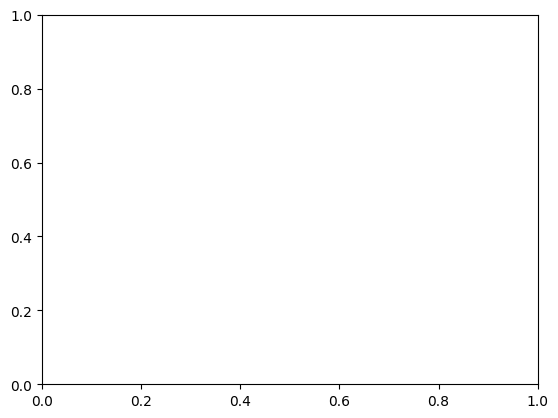

In [ ]:
#%matplotlib notebook

ax = plt.axes()
move.plot(ax)
plt.show()

save this movement to a file

In [ ]:
move.save(open('move.record', 'w'))

# D) Play the saved move in the simulator

In [ ]:
poppy_reset()

In [ ]:
from pypot.primitive.move import MovePlayer, MoveRecorder

In [ ]:
def smoothen_move(move):

    # Function to smoothen the Poppy movement
    n = 10

    # Create a tensor from the dictionary
    motors = move.positions()[0].keys()
    move_tensor = torch.Tensor([
        [move.positions()[t][motor]  for motor in motors] for t in move.positions().keys()
    ])

    # Control the motor range
    move_tensor = torch.minimum(move_tensor, torch.full(move_tensor.shape, 180.))
    move_tensor = torch.maximum(move_tensor, torch.full(move_tensor.shape, -180.))

    # Moving average to smoothen the positions
    move_tensor = moving_average(move_tensor, n=n)

    # Compute velocity as the (next position - previous positions) * fps / 2
    move_tensor[1:-1, :, 1] = (move_tensor[2:, :, 0] - move_tensor[:-2, :, 0]) * 0.5 * move.framerate

    # Rebuild the dictionary from the tensor
    new_move = Move(freq=move.framerate)

    for i in range(move_tensor.shape[0]):
        dictionary = {}
        for j, motor in enumerate(motors):
            dictionary[motor] = move_tensor[i, j].tolist()
        new_move.add_position(
            dictionary,
            float(i)/fps
        )

    return new_move

In [ ]:
new_move = smoothen_move(move)

In [ ]:
mp = MovePlayer(poppy, new_move)

In [ ]:
mp.start()

<IPython.core.display.Javascript object>


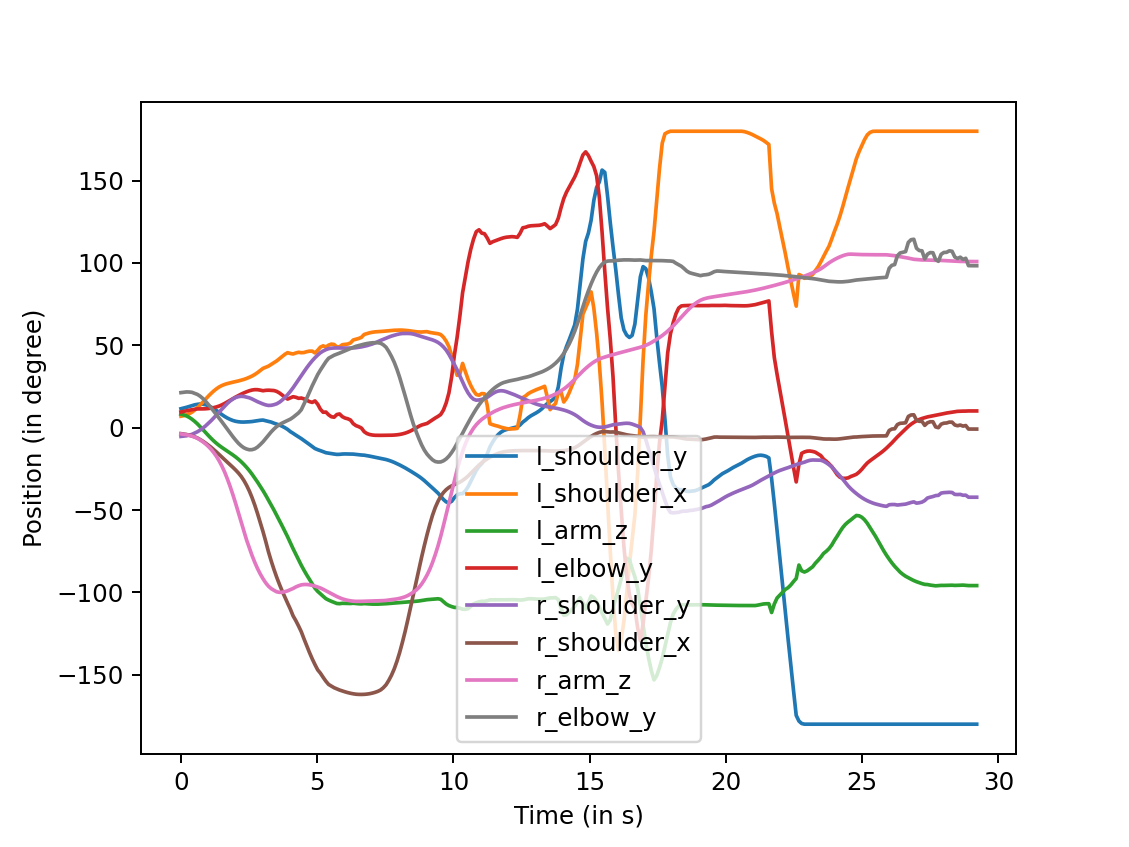

In [ ]:
%matplotlib notebook

ax = plt.axes()
new_move.plot(ax)
plt.show()

Finally, we save the move in a file, copy the file through ssh to the poppy robot, and send an API request to play the move. Note that the computer executing the notebook should be on the same network than poppy.